##### Imports

In [1]:
import warnings
warnings.filterwarnings("ignore")

import glob

from osgeo import gdal
from shapely import wkt

%load_ext autoreload
%autoreload 2
%env PROJ_LIB=/home/wwymak/anaconda3/envs/solaris/share/proj
%matplotlib inline

import rasterio
from torch.utils.tensorboard import SummaryWriter
import skimage
import geopandas as gpd
from matplotlib import pyplot as plt
from shapely.ops import cascaded_union
import solaris as sol

from tqdm import tqdm
import tifffile as sktif

import geopandas as gpd
import numpy as np
import cv2
from functools import partial

from fastai.imports import *
from fastai.vision import *
from fastai.metrics import dice
from fastai.callbacks import *
import ujson as json
from joblib import Parallel, delayed
import torch.nn.functional as F
import torch
import functools, traceback
def gpu_mem_restore(func):
    """Reclaim GPU RAM if CUDA out of memory happened, or execution was interrupted"""
    @functools.wraps(func)
    def wrapper(*args, **kwargs):
        try:
            return func(*args, **kwargs)
        except:
            type, val, tb = sys.exc_info()
            traceback.clear_frames(tb)
            raise type(val).with_traceback(tb) from None
    return wrapper

os.environ['FASTAI_TB_CLEAR_FRAMES']="1"
from importlib import reload

env: PROJ_LIB=/home/wwymak/anaconda3/envs/solaris/share/proj


W1108 21:42:15.462020 140675379242816 deprecation_wrapper.py:119] From /home/wwymak/anaconda3/envs/solaris2/lib/python3.7/site-packages/solaris/nets/metrics.py:103: The name tf.keras.metrics.cosine_proximity is deprecated. Please use tf.keras.losses.cosine_similarity instead.

W1108 21:42:15.537395 140675379242816 deprecation_wrapper.py:119] From /home/wwymak/anaconda3/envs/solaris2/lib/python3.7/site-packages/solaris/nets/_keras_losses.py:104: The name tf.keras.losses.cosine is deprecated. Please use tf.keras.losses.cosine_similarity instead.



##### Files

In [3]:
data_dir = Path("/media/wwymak/Storage/xView2")
mask_dir = data_dir /"mask_full_size"
mask_dir.mkdir(exist_ok=True)

train_images_crops = data_dir/"train_crops"
train_mask_crops = data_dir/"mask_crops"

train_mask_crops.mkdir(exist_ok=True)
train_images_crops.mkdir(exist_ok=True)

In [4]:
(data_dir/"test"/"images").ls()[:5]

[PosixPath('/media/wwymak/Storage/xView2/test/images/test_pre_00909.png'),
 PosixPath('/media/wwymak/Storage/xView2/test/images/test_pre_00371.png'),
 PosixPath('/media/wwymak/Storage/xView2/test/images/test_pre_00824.png'),
 PosixPath('/media/wwymak/Storage/xView2/test/images/test_post_00082.png'),
 PosixPath('/media/wwymak/Storage/xView2/test/images/test_post_00294.png')]

The images are both pre and post diaster, with naming scheme `f"{place}-{disaster_type}_{id}_{pre/post}_disaster.png`

In [5]:
(data_dir/"train"/"images").ls()[:5]

[PosixPath('/media/wwymak/Storage/xView2/train/images/palu-tsunami_00000024_post_disaster.png'),
 PosixPath('/media/wwymak/Storage/xView2/train/images/midwest-flooding_00000319_pre_disaster.png'),
 PosixPath('/media/wwymak/Storage/xView2/train/images/hurricane-matthew_00000005_post_disaster.png'),
 PosixPath('/media/wwymak/Storage/xView2/train/images/hurricane-florence_00000392_pre_disaster.png'),
 PosixPath('/media/wwymak/Storage/xView2/train/images/socal-fire_00000669_post_disaster.png')]

In [6]:
(data_dir/"tier3"/"images").ls()[:5]

[PosixPath('/media/wwymak/Storage/xView2/tier3/images/tuscaloosa-tornado_00000049_pre_disaster.png'),
 PosixPath('/media/wwymak/Storage/xView2/tier3/images/pinery-bushfire_00000195_post_disaster.png'),
 PosixPath('/media/wwymak/Storage/xView2/tier3/images/pinery-bushfire_00001695_pre_disaster.png'),
 PosixPath('/media/wwymak/Storage/xView2/tier3/images/lower-puna-volcano_00000274_post_disaster.png'),
 PosixPath('/media/wwymak/Storage/xView2/tier3/images/nepal-flooding_00000115_pre_disaster.png')]

In [7]:
len((data_dir/"train"/"images").ls()), len((data_dir/"tier3"/"images").ls())

(5598, 12738)

Likewise labels (in json) are named similarly 

In [8]:
(data_dir/"train"/"labels").ls()[:5]

[PosixPath('/media/wwymak/Storage/xView2/train/labels/socal-fire_00000521_post_disaster.json'),
 PosixPath('/media/wwymak/Storage/xView2/train/labels/hurricane-michael_00000047_pre_disaster.json'),
 PosixPath('/media/wwymak/Storage/xView2/train/labels/socal-fire_00001003_pre_disaster.json'),
 PosixPath('/media/wwymak/Storage/xView2/train/labels/socal-fire_00000580_post_disaster.json'),
 PosixPath('/media/wwymak/Storage/xView2/train/labels/socal-fire_00000671_post_disaster.json')]

##### Mask construction

Parsing one label:

In [9]:
with open('/media/wwymak/Storage/xView2/tier3/labels/nepal-flooding_00000115_post_disaster.json', 'r') as f:
    test_label = json.load(f)

In [10]:
test_label

{'features': {'lng_lat': [{'properties': {'feature_type': 'building',
     'subtype': 'destroyed',
     'uid': '5fbe9eb1-28c6-4581-82e5-534267dee6d5'},
    'wkt': 'POLYGON ((83.4343414907799 26.62406599738632, 83.43439624164986 26.62407889730963, 83.4344049913701 26.62405201401211, 83.4343491737345 26.6240388541861, 83.4343414907799 26.62406599738632))'},
   {'properties': {'feature_type': 'building',
     'subtype': 'destroyed',
     'uid': '1a8c9a1e-6e1c-4f09-88cd-b39496df8fa0'},
    'wkt': 'POLYGON ((83.43480222541162 26.62414633601181, 83.43482715059774 26.6241217310791, 83.43479246526172 26.62409749360998, 83.43476608649497 26.62412212343119, 83.43480222541162 26.62414633601181))'},
   {'properties': {'feature_type': 'building',
     'subtype': 'un-classified',
     'uid': '6370e97c-3dff-4a60-813b-653d53096b4c'},
    'wkt': 'POLYGON ((83.43493959576183 26.62417861668779, 83.43495501726764 26.62415156066483, 83.43491766018991 26.62413847782147, 83.43490515968203 26.62416613727285, 

(1024, 1024, 3)


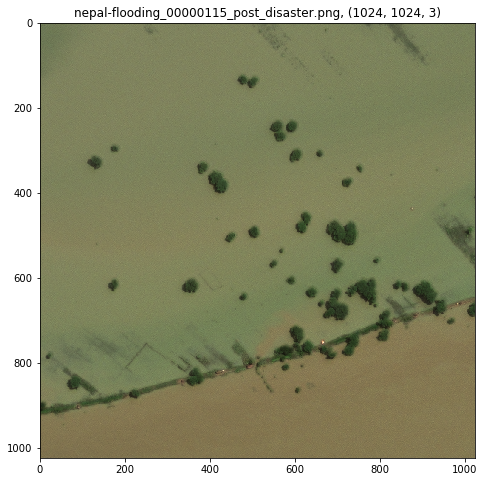

In [11]:
img_name = test_label['metadata']['img_name']
plt.figure(figsize=(8,8))
img = np.array(PIL.Image.open(data_dir/"tier3"/"images"/img_name))
plt.imshow(img);
plt.title(f"{img_name}, {img.shape}")
print(img.shape)

The xy field have the polygons in pixels

In [12]:
test_label['features']['xy']

[{'properties': {'feature_type': 'building',
   'subtype': 'destroyed',
   'uid': '5fbe9eb1-28c6-4581-82e5-534267dee6d5'},
  'wkt': 'POLYGON ((414.0515742108868 818.548670209474, 425.5231513564337 815.3067027555431, 427.4856218791386 821.5700722993338, 415.7905681311369 824.8772125010562, 414.0515742108868 818.548670209474))'},
 {'properties': {'feature_type': 'building',
   'subtype': 'destroyed',
   'uid': '1a8c9a1e-6e1c-4f09-88cd-b39496df8fa0'},
  'wkt': 'POLYGON ((510.7120603974473 797.8776274993739, 516.0705248274829 803.5422898962016, 508.8748725952265 809.3600512763015, 503.2102101988925 803.6953888794739, 510.7120603974473 797.8776274993739))'},
 {'properties': {'feature_type': 'building',
   'subtype': 'un-classified',
   'uid': '6370e97c-3dff-4a60-813b-653d53096b4c'},
  'wkt': 'POLYGON ((539.4946693294264 789.7633813623132, 542.8628469710154 796.0404396951836, 535.0547988009935 799.2555183527628, 532.2990170988929 792.8253610385891, 539.4946693294264 789.7633813623132))'},
 {

whereas the lng_lat field has the polygons in geocoords

In [13]:
test_label['features']['lng_lat']

[{'properties': {'feature_type': 'building',
   'subtype': 'destroyed',
   'uid': '5fbe9eb1-28c6-4581-82e5-534267dee6d5'},
  'wkt': 'POLYGON ((83.4343414907799 26.62406599738632, 83.43439624164986 26.62407889730963, 83.4344049913701 26.62405201401211, 83.4343491737345 26.6240388541861, 83.4343414907799 26.62406599738632))'},
 {'properties': {'feature_type': 'building',
   'subtype': 'destroyed',
   'uid': '1a8c9a1e-6e1c-4f09-88cd-b39496df8fa0'},
  'wkt': 'POLYGON ((83.43480222541162 26.62414633601181, 83.43482715059774 26.6241217310791, 83.43479246526172 26.62409749360998, 83.43476608649497 26.62412212343119, 83.43480222541162 26.62414633601181))'},
 {'properties': {'feature_type': 'building',
   'subtype': 'un-classified',
   'uid': '6370e97c-3dff-4a60-813b-653d53096b4c'},
  'wkt': 'POLYGON ((83.43493959576183 26.62417861668779, 83.43495501726764 26.62415156066483, 83.43491766018991 26.62413847782147, 83.43490515968203 26.62416613727285, 83.43493959576183 26.62417861668779))'},
 {'pro

In [14]:
def parse_json(label_json):
    df_xy =  pd.DataFrame([{'id':x['properties']['uid'], 'feature':x['properties']['feature_type'],
      'damage':x['properties'].get('subtype', 'no-damage'),
      'geometry_pixel':x['wkt']} for x in label_json['features']['xy']])
    df_lnglat = pd.DataFrame([{'id':x['properties']['uid'] ,'geometry_lnglat':x['wkt'],} for x in label_json['features']['lng_lat']])
    if len(df_xy) == 0:
        return
    df_xy.set_index('id', inplace=True)

    df_xy['damage_cls']= df_xy['damage'].map({
        'no-damage':1, 'minor-damage':2, 'major-damage':3, 'destroyed':4, 'un-classified':5
    })
    df_xy.geometry_pixel = df_xy.geometry_pixel.apply(wkt.loads)
    df_lnglat.set_index('id', inplace=True)
    label_df = df_xy.merge(df_lnglat['geometry_lnglat'], left_index=True, right_index=True)
    
    label_gdf = gpd.GeoDataFrame(label_df, geometry='geometry_pixel')
    label_gdf['centroid'] = label_gdf.geometry_pixel.centroid
    return label_gdf



In [15]:
label_gdf = parse_json(test_label)

In [16]:
label_gdf.head()

,feature,damage,geometry_pixel,damage_cls,geometry_lnglat,centroid
id,,,,,,
5fbe9eb1-28c6-4581-82e5-534267dee6d5,building,destroyed,"POLYGON ((414.0515742108868 818.548670209474, ...",4,"POLYGON ((83.4343414907799 26.62406599738632, ...",POINT (420.7154289571009 820.0858912063098)
1a8c9a1e-6e1c-4f09-88cd-b39496df8fa0,building,destroyed,"POLYGON ((510.7120603974473 797.8776274993739,...",4,"POLYGON ((83.43480222541162 26.62414633601181,...",POINT (509.6913031163605 803.6194480829027)
6370e97c-3dff-4a60-813b-653d53096b4c,building,un-classified,"POLYGON ((539.4946693294264 789.7633813623132,...",5,"POLYGON ((83.43493959576183 26.62417861668779,...",POINT (537.4556991332049 794.5079461235471)
7ce18618-1610-4377-b026-157ff057e982,building,destroyed,"POLYGON ((658.1454878038199 748.663465058232, ...",4,"POLYGON ((83.4355065718093 26.62434432826872, ...",POINT (662.4499784360601 750.1617079177953)
c60296ff-80f3-4069-95b6-fe9a8f8380c4,building,destroyed,"POLYGON ((959.943785213649 731.7290404088239, ...",4,"POLYGON ((83.43694079756837 26.62439203033719,...",POINT (958.6167121350931 736.1066917773886)


In [17]:
label_gdf.geometry

id
5fbe9eb1-28c6-4581-82e5-534267dee6d5    POLYGON ((414.0515742108868 818.548670209474, ...
1a8c9a1e-6e1c-4f09-88cd-b39496df8fa0    POLYGON ((510.7120603974473 797.8776274993739,...
6370e97c-3dff-4a60-813b-653d53096b4c    POLYGON ((539.4946693294264 789.7633813623132,...
7ce18618-1610-4377-b026-157ff057e982    POLYGON ((658.1454878038199 748.663465058232, ...
c60296ff-80f3-4069-95b6-fe9a8f8380c4    POLYGON ((959.943785213649 731.7290404088239, ...
a97742dc-dfc7-4ea4-aab5-7a669e485097    POLYGON ((996.1292887011487 715.3432015224191,...
Name: geometry_pixel, dtype: object

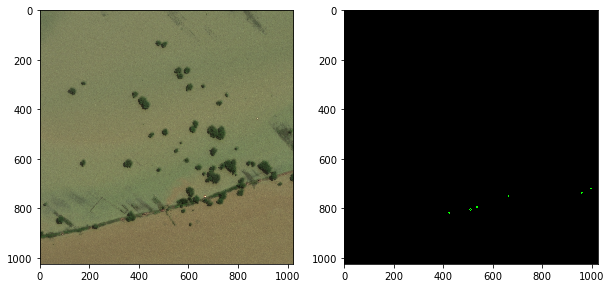

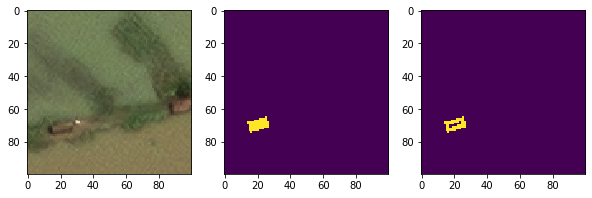

In [18]:
tile_size=1024
label_gdf = parse_json(test_label)
fp_mask = sol.vector.mask.footprint_mask(df=label_gdf,geom_col='geometry_pixel',
                                         burn_field='damage_cls', shape=(tile_size,tile_size))

boundary_mask = sol.vector.mask.boundary_mask(footprint_msk=fp_mask, 
    boundary_width=5, boundary_type='inner', burn_value=255)

combined_mask = np.rollaxis(np.stack([fp_mask, boundary_mask, np.zeros_like(fp_mask)]), 0,3)
fig, (ax1, ax2) = plt.subplots(1,2,figsize=(10, 5))
ax1.imshow(img)
ax2.imshow(combined_mask)

#zoom into the buildings
fig, (ax1, ax2, ax3) = plt.subplots(1,3,figsize=(10, 5))
ax1.imshow(img[750:850, 400:500])
ax2.imshow(fp_mask[750:850, 400:500])
ax3.imshow(boundary_mask[750:850, 400:500])

# contact_mask = sol.vector.mask.contact_mask(df=label_gdf.rename(columns={"geometry_pixel": "geometry"}),
# #                                             geom_col='geometry_pixel',
#     contact_spacing=10, meters=False, out_file=None, 
#     do_transform=None, affine_obj=None, shape=(tile_size,tile_size), burn_value=255)
# # f, ax = plt.subplots(figsize=(5,5))
# # plt.imshow(fp_mask/4 * 255)


# 
# test_mask = sol.vector.mask.df_to_px_mask(df=label_gdf.rename(columns={"geometry_pixel": "geometry"}),
#      channels=['footprint', 'boundary', 'contact'],#do_transform=False,
#      shape=(tile_size,tile_size),
# #      boundary_width=5, 
#      boundary_type='inner', contact_spacing=5, meters=False)

# print(test_mask.shape)
# fig, (ax1, ax2) = plt.subplots(1,2,figsize=(10, 5))
# ax1.imshow(np.moveaxis(test_mask,0,2))
# ax2.imshow(fbc_mask)

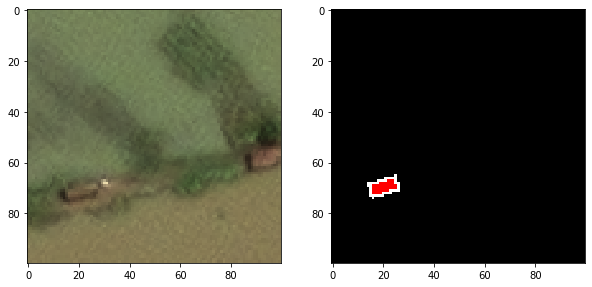

In [31]:
fb_mask = sol.vector.mask.df_to_px_mask(df=label_gdf, geom_col="geometry_pixel",
                                         channels=['footprint', 'boundary','boundary'],
                                         shape=(tile_size,tile_size),
                                         boundary_width=3, boundary_type='inner')

fig, (ax1, ax2) = plt.subplots(1,2,figsize=(10, 5))
ax1.imshow(img[750:850, 400:500])
ax2.imshow(fb_mask[750:850, 400:500])

In [36]:
def create_mask(json_file):
    with open(data_dir/"train"/"labels"/json_file, 'r') as f:
        label = json.load(f)
    df = parse_json(label)
    if df is None or len(df) == 0:
        return
    fb_mask = sol.vector.mask.df_to_px_mask(df=label_gdf, geom_col="geometry_pixel",
                                         channels=['footprint', 'boundary','boundary'],
                                         shape=(tile_size,tile_size),
                                         boundary_width=3, boundary_type='inner')
    PIL.Image.fromarray(fb_mask).save(mask_dir/(json_file.replace('.json', '.png')))

In [37]:
undamaged_fnames = [fname.name for fname in (data_dir/"train"/"labels").ls() if 'pre_disaster' in fname.name]
%time _=Parallel(n_jobs=16)(delayed(create_mask)(f) for f in undamaged_fnames)

CPU times: user 2.37 s, sys: 32.6 ms, total: 2.4 s
Wall time: 14.6 s


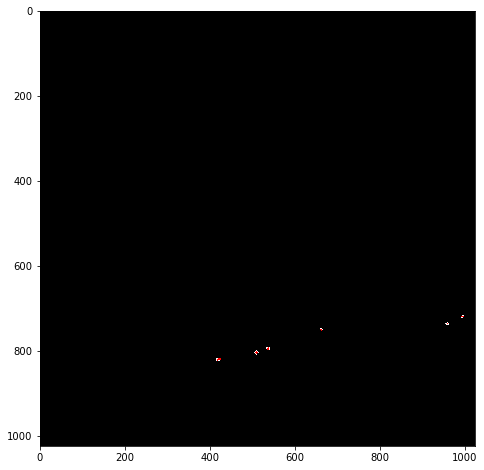

In [40]:
plt.figure(figsize=(8,8))
plt.imshow(np.array(PIL.Image.open(str(mask_dir/undamaged_fnames[18]).replace('.json', '.png'))))

In [26]:
df = label_gdf.copy()
print(df.crs)
geom_col = "geometry_pixel"
contact_spacing=10
meters=False
reference_im=None
affine_obj=None
df[geom_col] = df[geom_col].apply(sol.vector.mask._check_geom)  # load in geoms if wkt
df[geom_col] = df[geom_col].buffer(3)

df_for_buffer = df.copy()
buffered_geoms =sol.vector.mask.buffer_df_geoms(df, contact_spacing/2., meters=False,
                                 reference_im=reference_im,
                                 geom_col=geom_col, affine_obj=affine_obj)
# buffered_geoms = buffered_geoms[geom_col]
# create a single multipolygon that covers all of the intersections
# intersect_poly = geometries_internal_intersection(buffered_geoms)

# # handle case where there's no intersection
# if intersect_poly.is_empty:
#     output_arr = np.zeros(shape=shape, dtype='uint8')

# else:
#     # create a df containing the intersections to make footprints from
#     df_for_footprint = pd.DataFrame({'shape_name': ['overlap'],
#                                      'geometry': [intersect_poly]})
#     # catch bowties
#     df_for_footprint['geometry'] = df_for_footprint['geometry'].apply(
#         lambda x: x.buffer(0)
#     )
#     # use `footprint_mask` to create the overlap mask
#     contact_msk = footprint_mask(
#         df_for_footprint, reference_im=reference_im, geom_col='geometry',
#         do_transform=do_transform, affine_obj=affine_obj, shape=shape,
#         out_type=out_type, burn_value=burn_value
#     )
#     footprint_msk = footprint_mask(
#         df, reference_im=reference_im, geom_col=geom_col,
#         do_transform=do_transform, affine_obj=affine_obj, shape=shape,
#         out_type=out_type, burn_value=burn_value
#     )
#     contact_msk[footprint_msk > 0] = 0
#     contact_msk = contact_msk > 0
#     output_arr = contact_msk.astype('uint8')*burn_value



None


KeyError: 'geometry'

In [29]:
def buffer_df_geoms(df, buffer, meters=False, reference_im=None,
                    geom_col='geometry', affine_obj=None):
    """Buffer geometries within a pd.DataFrame or gpd.GeoDataFrame.

    Arguments
    ---------
    df : :class:`pandas.DataFrame` or :class:`geopandas.GeoDataFrame`
        A :class:`pandas.DataFrame` or :class:`geopandas.GeoDataFrame` instance
        with a column containing geometries (identified by `geom_col`). If `df`
        lacks a ``crs`` attribute (isn't a :class:`geopandas.GeoDataFrame` )
        and ``meters=True``, then `reference_im` must be provided for
        georeferencing.
    buffer : `int` or `float`
        The amount to buffer the geometries in `df`. In pixel units unless
        ``meters=True``. This corresponds to width/2 in mask creation
        functions.
    meters : bool, optional
        Should buffers be in pixel units (default) or metric units (if `meters`
        is ``True``)?
    reference_im : `str` or :class:`rasterio.DatasetReader`, optional
        The path to a reference image covering the same geographic extent as
        the area labeled in `df`. Provided for georeferencing of pixel
        coordinate geometries in `df` or conversion of georeferenced geometries
        to pixel coordinates as needed. Required if `meters` is ``True`` and
        `df` lacks a ``crs`` attribute.
    geom_col : str, optional
        The column containing geometries in `df`. Defaults to ``"geometry"``.
    affine_obj : `list` or :class:`affine.Affine`, optional
        Affine transformation to use to convert geoms in `df` from a geographic
        crs to pixel space. Only provide this argument if `df` is a
        :class:`geopandas.GeoDataFrame` with coordinates in a georeferenced
        coordinate space. Ignored if `reference_im` is provided.

    Returns
    -------
    buffered_df : :class:`pandas.DataFrame`
        A :class:`pandas.DataFrame` in the original coordinate reference system
        with objects buffered per `buffer`.

    See Also
    --------
    road_mask : Function to create road network masks.
    contact_mask : Function to create masks of contact points between polygons.
    """
    if reference_im is not None:
        reference_im = _check_rasterio_im_load(reference_im)

    if hasattr(df, 'crs'):
        orig_crs = df.crs
    else:
        orig_crs = None  # will represent pixel crs
        
    print(orig_crs, 'orig_crs')

    # Check if dataframe is in the appropriate units and reproject if not
    if not meters:
        print('not meters')
        if hasattr(df, 'crs') and reference_im is not None:
            # if the df is georeferenced and a reference_im is provided,
            # use reference_im to transform df to px coordinates
            df_for_buffer = geojson_to_px_gdf(df.copy(), reference_im)
        elif hasattr(df, 'crs') and reference_im is None:
            df_for_buffer = affine_transform_gdf(df.copy(),
                                                 affine_obj=affine_obj)
        else:  # if it's already in px coordinates
            df_for_buffer = df.copy()
            print('df_for_buffer')

    else:
        # check if the df is in a metric crs
        if hasattr(df, 'crs'):
            if crs_is_metric(df):
                df_for_buffer = df.copy()
            else:
                df_for_buffer = reproject(df.copy())  # defaults to UTM
        else:
            # assume df is in px coords - use reference_im to georegister
            if reference_im is not None:
                df_for_buffer = georegister_px_df(df.copy(),
                                                  im_path=reference_im)
            else:
                raise ValueError('If using `meters=True`, either `df` must be '
                                 'a geopandas GeoDataFrame or `reference_im` '
                                 'must be provided for georegistration.')

    df_for_buffer[geom_col] = df_for_buffer[geom_col].apply(
        lambda x: x.buffer(buffer))
    
    print('df_for_buffer', 'here2')
    print(getattr(df_for_buffer, 'crs', None) != orig_crs)

    # return to original crs
    if getattr(df_for_buffer, 'crs', None) != orig_crs:
        if orig_crs is not None and \
                getattr(df_for_buffer, 'crs', None) is not None:
            buffered_df = df_for_buffer.to_crs(orig_crs)
        elif orig_crs is None:  # but df_for_buffer has one: meters=True case
            buffered_df = geojson_to_px_gdf(df_for_buffer, reference_im)
        else:  # orig_crs exists, but df_for_buffer doesn't have one
            buffered_df = georegister_px_df(df_for_buffer,
                                            im_path=reference_im,
                                            affine_obj=affine_obj,
                                            crs=orig_crs)
    else:
        buffered_df = df_for_buffer

    return buffered_df
print(hasattr(df, 'crs'))
buffer_df_geoms(df, 3, meters=False, reference_im=None,
                    geom_col='geometry_pixel', affine_obj=None)

True
None orig_crs
not meters


NameError: name 'affine_transform_gdf' is not defined

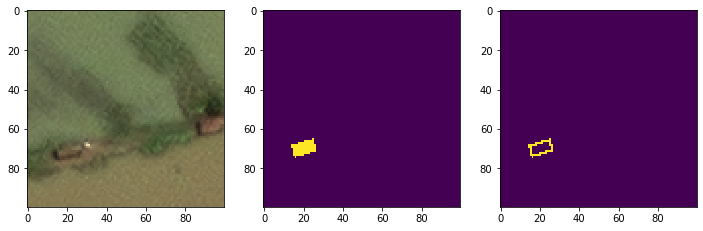

In [29]:
fig, (ax3,ax1, ax2) = plt.subplots(1,3,figsize=(12, 4))
ax1.imshow(fb_mask[750:850, 400:500,0])
ax2.imshow(fb_mask[750:850, 400:500,1])
ax3.imshow(img[750:850, 400:500])

Let's try to get a really good localisation segmentation first

In [3]:
def create_mask_pre_disaster(json_file):
    with open(data_dir/"train"/"labels"/json_file, 'r') as f:
        label = json.load(f)
    df = parse_json(label)
    if df is None or len(df) == 0:
        return
    fp_mask = sol.vector.mask.footprint_mask(df=parse_json(label),geom_col='geometry_pixel',
                                         burn_field='damage_cls', shape=(1024,1024))
    PIL.Image.fromarray(fp_mask).save(mask_dir/(json_file.replace('.json', '.png')))

In [25]:
# test mask creation
create_mask('socal-fire_00000521_post_disaster.json')
create_mask('socal-fire_00000521_pre_disaster.json')
test_mask_pre = PIL.Image.open(mask_dir/"socal-fire_00000521_pre_disaster.png")
test_mask_post = PIL.Image.open(mask_dir/"socal-fire_00000521_post_disaster.png")

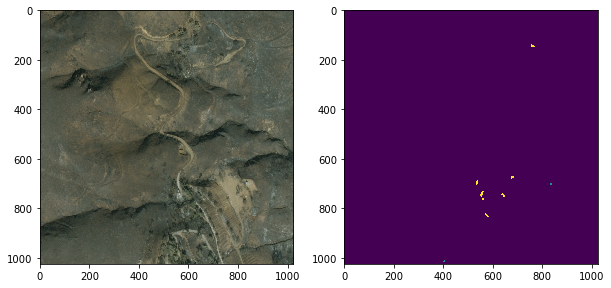

In [47]:
f, ax = plt.subplots(1,2,figsize=(10,5))
axs = ax.ravel()
axs[1].imshow(np.array(test_mask_post)/4 * 255)
axs[0].imshow(np.array(PIL.Image.open(data_dir/"train"/"images"/"socal-fire_00000521_post_disaster.png")))

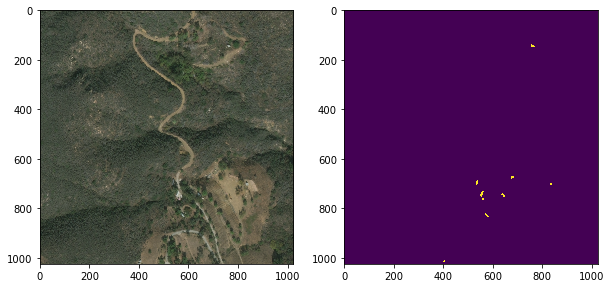

In [48]:
f, ax = plt.subplots(1,2,figsize=(10,5))
axs = ax.ravel()
axs[1].imshow(np.array(test_mask_pre)/4 * 255)
axs[0].imshow(np.array(PIL.Image.open(data_dir/"train"/"images"/"socal-fire_00000521_pre_disaster.png")))

Zooming into the houses:

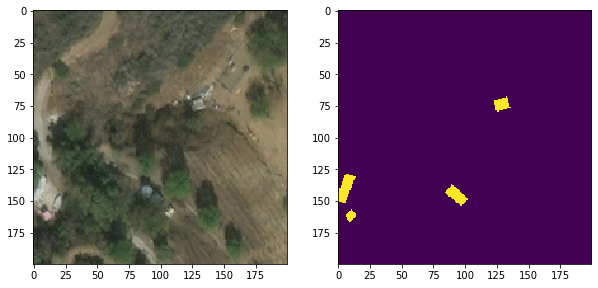

In [9]:
f, ax = plt.subplots(1,2,figsize=(10,5))
axs = ax.ravel()
axs[1].imshow(np.array(test_mask_pre)[600:800, 550:750]/4 * 255)
axs[0].imshow(np.array(PIL.Image.open(data_dir/"train"/"images"/"socal-fire_00000521_pre_disaster.png"))[600:800, 550:750])

##### A smarter way of going about things

(more or less reusing the creating crops function in spacenet roads project)

In [133]:
# %time _=Parallel(n_jobs=16)(delayed(create_mask)(fname.name) for fname in (data_dir/"train"/"labels").ls())
# from tqdm import tqdm

_= [create_mask(fname.name) for fname in tqdm((data_dir/"train"/"labels").ls())]




  0%|          | 0/5598 [00:00<?, ?it/s]


  0%|          | 9/5598 [00:00<01:08, 81.51it/s]


  0%|          | 18/5598 [00:00<01:07, 82.99it/s]


  0%|          | 24/5598 [00:00<01:20, 69.57it/s]


  1%|          | 31/5598 [00:00<01:20, 69.52it/s]


  1%|          | 37/5598 [00:00<01:26, 64.48it/s]


  1%|          | 43/5598 [00:00<01:29, 61.80it/s]


  1%|          | 51/5598 [00:00<01:25, 65.04it/s]


  1%|          | 58/5598 [00:00<01:40, 55.12it/s]


  1%|          | 64/5598 [00:01<01:39, 55.75it/s]


  1%|▏         | 75/5598 [00:01<01:25, 64.83it/s]


  1%|▏         | 83/5598 [00:01<01:21, 67.62it/s]


  2%|▏         | 91/5598 [00:01<01:24, 64.82it/s]


  2%|▏         | 98/5598 [00:01<01:30, 60.62it/s]


  2%|▏         | 105/5598 [00:01<01:37, 56.51it/s]


  2%|▏         | 114/5598 [00:01<01:27, 62.84it/s]


  2%|▏         | 124/5598 [00:01<01:20, 68.34it/s]


  2%|▏         | 132/5598 [00:02<01:25, 64.29it/s]


  2%|▏         | 139/5598 [00:02<01:36, 56.74it/s]


  3%|▎        

 36%|███▌      | 2003/5598 [00:32<00:55, 64.61it/s]


 36%|███▌      | 2010/5598 [00:32<00:57, 62.91it/s]


 36%|███▌      | 2017/5598 [00:32<00:56, 62.83it/s]


 36%|███▌      | 2025/5598 [00:32<00:56, 62.96it/s]


 36%|███▋      | 2034/5598 [00:33<00:52, 68.15it/s]


 36%|███▋      | 2042/5598 [00:33<00:51, 69.68it/s]


 37%|███▋      | 2050/5598 [00:33<00:50, 69.87it/s]


 37%|███▋      | 2058/5598 [00:33<00:57, 61.59it/s]


 37%|███▋      | 2067/5598 [00:33<00:52, 67.44it/s]


 37%|███▋      | 2075/5598 [00:33<01:00, 58.62it/s]


 37%|███▋      | 2082/5598 [00:33<01:00, 58.19it/s]


 37%|███▋      | 2090/5598 [00:33<00:56, 61.92it/s]


 37%|███▋      | 2097/5598 [00:34<00:54, 63.95it/s]


 38%|███▊      | 2104/5598 [00:34<00:57, 60.35it/s]


 38%|███▊      | 2111/5598 [00:34<01:01, 56.71it/s]


 38%|███▊      | 2117/5598 [00:34<01:01, 56.60it/s]


 38%|███▊      | 2124/5598 [00:34<00:59, 58.21it/s]


 38%|███▊      | 2134/5598 [00:34<00:52, 65.69it/s]


 38%|███▊      | 2142/5598 [

 69%|██████▊   | 3847/5598 [01:06<00:29, 58.65it/s]


 69%|██████▉   | 3855/5598 [01:06<00:32, 53.63it/s]


 69%|██████▉   | 3862/5598 [01:06<00:34, 50.76it/s]


 69%|██████▉   | 3869/5598 [01:06<00:31, 55.24it/s]


 69%|██████▉   | 3876/5598 [01:06<00:34, 49.23it/s]


 69%|██████▉   | 3882/5598 [01:06<00:39, 43.36it/s]


 69%|██████▉   | 3887/5598 [01:07<00:40, 42.23it/s]


 70%|██████▉   | 3895/5598 [01:07<00:35, 47.97it/s]


 70%|██████▉   | 3901/5598 [01:07<00:36, 46.75it/s]


 70%|██████▉   | 3908/5598 [01:07<00:33, 50.64it/s]


 70%|██████▉   | 3914/5598 [01:07<00:33, 50.61it/s]


 70%|███████   | 3920/5598 [01:07<00:34, 48.87it/s]


 70%|███████   | 3926/5598 [01:07<00:33, 49.38it/s]


 70%|███████   | 3932/5598 [01:08<00:45, 36.82it/s]


 70%|███████   | 3939/5598 [01:08<00:38, 42.76it/s]


 71%|███████   | 3948/5598 [01:08<00:51, 32.12it/s]


 71%|███████   | 3954/5598 [01:08<00:46, 35.68it/s]


 71%|███████   | 3962/5598 [01:08<00:38, 42.21it/s]


 71%|███████   | 3968/5598 [

 99%|█████████▉| 5538/5598 [01:41<00:01, 51.08it/s]


 99%|█████████▉| 5544/5598 [01:41<00:01, 48.03it/s]


 99%|█████████▉| 5550/5598 [01:41<00:00, 49.06it/s]


 99%|█████████▉| 5558/5598 [01:41<00:00, 55.48it/s]


 99%|█████████▉| 5565/5598 [01:41<00:00, 54.04it/s]


100%|█████████▉| 5571/5598 [01:41<00:00, 54.64it/s]


100%|█████████▉| 5577/5598 [01:41<00:00, 53.85it/s]


100%|█████████▉| 5583/5598 [01:41<00:00, 50.58it/s]


100%|█████████▉| 5594/5598 [01:42<00:00, 58.52it/s]


100%|██████████| 5598/5598 [01:42<00:00, 54.84it/s]

In [6]:
def create_small_tiles(img_filepath, mask_filepath, im_id, save_dir_rgb, save_dir_mask):
    if not mask_filepath.exists():
        return
    img_rgb = PIL.Image.open(img_filepath)
    mask_im = PIL.Image.open(mask_filepath)

#     mask = np.array(mask_im)
    if mask_im.getextrema()[1] == 0:
        return
    
#     box = left, upper, right, and lower pixe

    boxes = [
        (0, 0, 512, 512),
        (0, 256, 512, 768),
        (0, 512,512, 1024),
        (256, 0, 768, 512),
        (256, 256, 768, 768),
        (256, 512, 768, 1024),
        (512,0, 1024, 512),
        (512,256, 1024, 768),
        (512,512,1024,1024)
    ]
    
    mask_crops = [mask_im.crop(box) for box in boxes]
    im_crops = [img_rgb.crop(box) for box in boxes]
    

    img_names = [save_dir_rgb/ f"rgb_{im_id}_{i}.png" for i in range(4)]
    mask_names = [save_dir_mask/ f"mask_{im_id}_{i}.png" for i in range(4)]
    
    for i, (mask_crop, im_crop) in enumerate(zip(mask_crops, im_crops)):
        mask_max = mask_crop.getextrema()[1]
        if mask_max > 0:
            mask_crop.save(save_dir_mask/ f"mask_{im_id}_{i}.png")
            im_crop.save(save_dir_rgb/ f"rgb_{im_id}_{i}.png")
            
 

Other than segmentation, it would be interesting to see if we can tell what sort of disaster it is from the satellite images...